In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Conv2D

from deepssfp import phantom, dataloader, view, recon, dataset, dataformatter, deepssfp, models

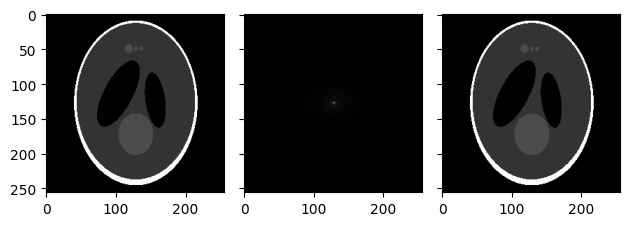

In [2]:
img = phantom.phantom_generator(256)
kSpace = np.fft.ifftshift(np.fft.fft2(img))
inverse = np.fft.ifft2(kSpace)

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(np.abs(kSpace), cmap='gray')
axs[2].imshow(np.abs(inverse), cmap='gray')
plt.show()

In [3]:
def generate_training_data(samples = 1000, height = 128, width = 128):
    img = np.random.randn(samples, height, width) + 1j* np.random.randn(samples, height, width) 

    kSpace = np.fft.ifftshift(np.fft.fft2(img))
    inverse = np.fft.ifft2(kSpace)

    inputs = np.stack((np.abs(kSpace), np.angle(kSpace)), axis = 3)
    outputs = np.stack((np.abs(inverse), np.angle(inverse)), axis = 3)
    return inputs, outputs

In [4]:
def generate_test_data(size = 128):
    img = phantom.phantom_generator(128)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    kSpace = np.fft.ifftshift(np.fft.fft2(img))
    inverse = np.fft.ifft2(kSpace)

    input = np.dstack((np.abs(kSpace), np.angle(kSpace)))
    output = np.dstack((np.abs(inverse), np.angle(inverse)))
    
    return input, output 

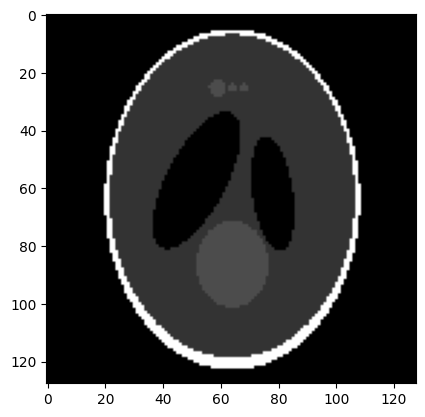

Training DataSet: (10000, 128, 128, 2) (10000, 128, 128, 2)
Test DataSet: (128, 128, 2) (128, 128, 2)


In [5]:
N = 10000
size = 128
x_train, y_train = generate_training_data(N, size, size)
x_test, y_test = generate_test_data(size)

print("Training DataSet: " + str(x_train.shape) + " " + str(y_train.shape))
print("Test DataSet: " + str(x_test.shape) + " " + str(y_test.shape))

In [6]:
def conv_net(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS):
    xin = keras.Input(shape=(HEIGHT, WIDTH, CHANNELS), name='img')
    x = Conv2D(32, (3, 3), padding="same", activation=tf.nn.relu)(xin)
    x = Conv2D(32, (3, 3), padding="same", activation=tf.nn.relu)(x)
    xout = Conv2D(NUM_OUTPUTS, (1, 1), padding="same", activation=None)(x)
    return tf.keras.Model(inputs=xin, outputs=xout)

In [7]:
# Training Parameters
num_epochs = 50
batch_size = 128 

# Network Parameters
WIDTH = 128
HEIGHT = 128
CHANNELS = 2
NUM_OUTPUTS = 2

In [8]:
model = conv_net(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()
model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      608       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 2)       66        
                                                                 
Total params: 9,922
Trainable params: 9,922
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 8s 34ms/step - loss: 234.4135
Epoch 2/50
79/79 [==============================] - 3s 33ms/step - loss: 54.1814
Epoch 3/50
79/79 [==========

1/1 [==============================] - 0s 18ms/step


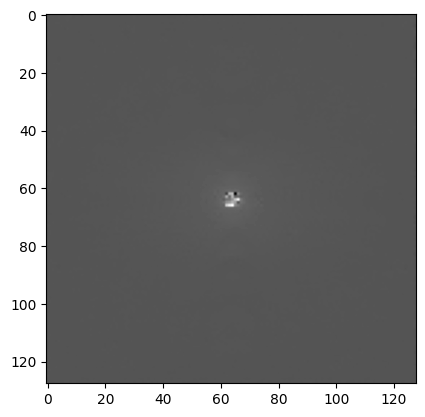

In [10]:
img = model.predict(x_test[np.newaxis, ...])
img = img[0,:,:,0]
plt.imshow(img, cmap='gray')
plt.show()